## Pre-Processing
### Data Loading and Cleaning

Here we will be using pandas to handle storing and processing the data

In [2]:
import pandas as pd

In [3]:
def remove_cols(df, cols):
    for col in cols:
        del df[col]
    return df

In [4]:
def get_clean_df():
    df = pd.read_csv("data/nba_games.csv",index_col=0)  #pulling the csv file from our parsed csv dataset
    df = df.sort_values("date")     #and sorting the data by date
    df = df.reset_index(drop=True)  #resetting the index and dropping the old index
    df = remove_cols(df, ["mp.1","mp_opp.1","index_opp"]) #removing unnecessary cols
    
    seasons = df['season'].unique()   # returns seasons in order of appearance
    last_two_seasons = seasons[-2:]   # get the last 2 seasons

    # Filter DataFrame
    df = df[df['season'].isin(last_two_seasons)]
    return df

Here we are trying to find out whether or not a given team will win their next game. We can train the data on the result we know from the next game by shifting the "won" column back by one and assigning it to target.

In [5]:
def add_target(team):
    team["target"] = team["won"].shift(-1)
    return team

When looking to shift the "won" column back to the previous, we must group the data by teams. We'd only shift a teams win back using the respective team's wins. For example, get all results where team_x is "GSW" and shift their games forward to find how they did in the next game (our target)

In [6]:
def group_teams(df):
    df = df.groupby("team",group_keys=False).apply(add_target).copy() #group by teams and shift corresponding "won" column back
    df["target"][pd.isnull(df["target"])] = 2   #If there isnt a next game change null value to 2
    df["target"] = df["target"].astype(int, errors="ignore")   #turn all target values to integer for model training

    return df

In [7]:
def remove_null_values(df):
    nulls = pd.isnull(df)
    nulls = nulls.sum()
    nulls = nulls[nulls > 0]
    
    valid_columns = df.columns[~df.columns.isin(nulls.index)]   #all columns which dont contain null values
    df = df[valid_columns].copy()
    
    return df

In [8]:
df = get_clean_df()
df = group_teams(df)
df = remove_null_values(df)

C:\Users\henry\AppData\Local\Temp\ipykernel_18220\309807057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"][pd.isnull(df["target"])] = 2   #If there isnt a next game change null value to 2


Scaling all the column values for training, making sure to remove values which are invalid for scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])

Splits the dataframe into two groups, home and away. Then on each group it applies a function which returns the number of games won in that group / the number of games in that group (win percentage)

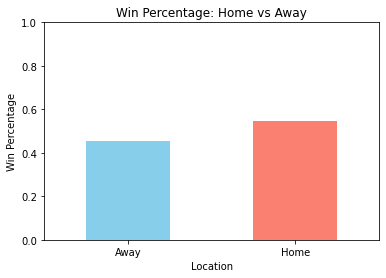

In [13]:
import matplotlib.pyplot as plt

# Calculate win percentages for home vs away
win_pct = df.groupby("home").apply(lambda x: x[x["won"] == 1].shape[0] / x.shape[0])

# Plot bar chart
plt.figure(figsize=(6,4))
win_pct.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Win Percentage: Home vs Away")
plt.xlabel("Location")
plt.ylabel("Win Percentage")
plt.xticks(ticks=[0,1], labels=['Away', 'Home'], rotation=0)
plt.ylim(0,1)
plt.show()

As we can see, teams often perform better at home than away. We can include a ‘home/away’ feature in the model to account for this when making predictions.

To find if a team has been on a hot streak, we can look at the rolling average from the previous x games.

In [10]:
def find_team_averages(team):
    rolling = team.rolling(10).mean()
    return rolling

df_rolling = df[list(selected_columns) + ["won", "team", "season"]]
df_rolling = df_rolling.groupby(["team", "season"], group_keys=False).apply(find_team_averages)

C:\Users\henry\AppData\Local\Temp\ipykernel_15424\1640615582.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['team'], dtype='object')
  rolling = team.rolling(10).mean()


Adding all rolling columns to the original dataframe with a new label.

In [11]:
rolling_cols = [f"{col}_10" for col in df_rolling.columns]
df_rolling.columns = rolling_cols

df = pd.concat([df, df_rolling], axis=1)

In [12]:
df = df.dropna() #Drop all null/na values

Finding out details about the next match for each team, who's at home, who are they playing, and what date the match is.

In [13]:
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby("team", group_keys=False).apply(lambda x: shift_col(x, col_name))

df["home_next"] = add_col(df, "home")
df["team_opp_next"] = add_col(df, "team_opp")
df["date_next"] = add_col(df, "date")

df = df.copy()

In [14]:
full = df.merge(
    df[rolling_cols + ["team_opp_next", "date_next", "team"]], 
    left_on=["team", "date_next"], 
    right_on=["team_opp_next", "date_next"]
)

In [15]:
full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]

,team_x,team_opp_next_x,team_y,team_opp_next_y,date_next
0,NOP,DAL,DAL,NOP,2023-11-14
1,SAS,OKC,OKC,SAS,2023-11-14
2,PHO,MIN,MIN,PHO,2023-11-15
3,OKC,SAS,SAS,OKC,2023-11-14
4,DAL,NOP,NOP,DAL,2023-11-14
...,...,...,...,...,...
4683,IND,OKC,OKC,IND,2025-06-16
4684,IND,OKC,OKC,IND,2025-06-19
4685,OKC,IND,IND,OKC,2025-06-19
4686,OKC,IND,IND,OKC,2025-06-22


In [16]:
removed_columns = list(full.columns[full.dtypes == "object"]) + removed_columns

In [17]:
selected_columns = full.columns[~full.columns.isin(removed_columns)]

In [18]:
full.head()

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,orb,...,tov%_max_opp_10_y,usg%_max_opp_10_y,ortg_max_opp_10_y,drtg_max_opp_10_y,total_opp_10_y,home_opp_10_y,won_10_y,season_10_y,team_opp_next_y,team_y
0,0.0,0.581395,0.480769,0.567961,0.555556,0.470588,0.659574,0.295455,0.415094,0.464286,...,0.454457,0.167784,0.336735,0.554444,0.532632,0.5,0.8,2024.0,NOP,DAL
1,0.0,0.465116,0.461538,0.449029,0.629630,0.627451,0.594108,0.227273,0.226415,0.392857,...,0.320761,0.173196,0.360204,0.473333,0.495789,0.4,0.6,2024.0,SAS,OKC
2,0.0,0.232558,0.307692,0.264563,0.259259,0.333333,0.394435,0.590909,0.584906,0.571429,...,0.386630,0.279253,0.370408,0.454444,0.377895,0.5,0.8,2024.0,PHO,MIN
3,0.0,0.418605,0.288462,0.512136,0.296296,0.294118,0.492635,0.477273,0.471698,0.214286,...,0.357609,0.162629,0.396429,0.414444,0.602105,0.5,0.3,2024.0,OKC,SAS
4,0.0,0.651163,0.673077,0.516990,0.666667,0.803922,0.504092,0.363636,0.396226,0.285714,...,0.390217,0.190206,0.481633,0.414444,0.517895,0.5,0.4,2024.0,DAL,NOP


In [19]:
full.to_pickle('df_nba_games.pkl')